In [86]:
import wandb
from tqdm import tqdm
import pandas as pd
import pickle
api = wandb.Api(timeout=100)



In [87]:
metrics = [
    'IphyreAdversarialHandDesignBlockAngleEnv-v0',
'IphyreAdversarialHandDesignBlockAngleHardEnv-v0',
'IphyreAdversarialHandDesignBlockNoGapEnv-v0',
'IphyreAdversarialHandDesignBlockOrderEnv-v0',
'IphyreAdversarialHandDesignConfuseEnv-v0',
'IphyreAdversarialHandDesignDoubleEnv-v0',
'IphyreAdversarialHandDesignDownEnv-v0',
'IphyreAdversarialHandDesignHighBallEnv-v0',
'IphyreAdversarialHandDesignHighGapEnv-v0',
'IphyreAdversarialHandDesignOutsideEnv-v0',
'IphyreAdversarialHandDesignReverseEnv-v0',
'IphyreAdversarialHandDesignRightEnv-v0',
'IphyreAdversarialHandDesignSkipGapEnv-v0',
'IphyreAdversarialHandDesignSkipGapHardEnv-v0',
'IphyreAdversarialHandDesignSwapEnv-v0',
]

In [88]:
import os
import datetime
print(f"Fetching data...")
# api.flush()
runs = api.runs(
    path="yqkqknct/dcd", 
    filters={"config.exp_name": {"$in": ["ued_iphyre_finetune_single_full"]},
            #  "config.env_name": {"$in": ["IphyreAdversarialHandDesignBlockAngleEnv-v0"]}
             },
    per_page=500
)
print(f"Found {len(runs)} runs")

# Create directory for run data if it doesn't exist
os.makedirs("run_data", exist_ok=True)

method_run_data = {}

# Process each run
none_counter = 0
index = 1
for run in runs:
    run_id = run.id
    method = run.config.get('method')
    
    if method == 'Iphyre-Single-From-Scratch':
        model = 'none_{}'.format(none_counter)
        none_counter += 1
    else:
        model = run.config.get('model_path').split('/')[-1].split('.')[0]
    # ./scripts/20250627/SFL_0.pt

    env_name = run.config.get('env_name')

    print(f"{index} of {len(runs)} Run id {run_id} | state: {run.state} | env {env_name} | model {model} | method: {method} | name: {run.name}")
    index += 1
    # Get run data
    if model not in method_run_data:
        method_run_data[model] = {
            'model': model,
            'method': model.split('_')[0],
            'metrics': {}
        }

    # Get history for each metric
    history = run.history(keys=['global_step', 'mean_agent_return'])
    method_run_data[model]['metrics'][env_name] = history[['global_step', 'mean_agent_return']]

    print(f'Update method_run_data[{model}][metrics][{env_name}]')

        
# Save run data to pickle file
with open('full_run_data.pkl', 'wb') as f:
    pickle.dump(method_run_data, f)


Fetching data...
Found 363 runs
1 of 363 Run id 0r3wgf82 | state: finished | env IphyreAdversarialHandDesignBlockAngleEnv-v0 | model ACCEL_0 | method: Iphyre-Single-Finetune-Accel | name: Iphyre-Single-Finetune-Accel_20250628-123134_234
Update method_run_data[ACCEL_0][metrics][IphyreAdversarialHandDesignBlockAngleEnv-v0]
2 of 363 Run id 3nlt2zcz | state: finished | env IphyreAdversarialHandDesignBlockAngleEnv-v0 | model VAccel_0 | method: Iphyre-Single-Finetune-VAccel | name: Iphyre-Single-Finetune-VAccel_20250628-123134_114
Update method_run_data[VAccel_0][metrics][IphyreAdversarialHandDesignBlockAngleEnv-v0]
3 of 363 Run id 5i1g12wb | state: finished | env IphyreAdversarialHandDesignBlockAngleEnv-v0 | model VSFL_0 | method: Iphyre-Single-Finetune-VSFL | name: Iphyre-Single-Finetune-VSFL_20250628-123134_138
Update method_run_data[VSFL_0][metrics][IphyreAdversarialHandDesignBlockAngleEnv-v0]
4 of 363 Run id f7txdqum | state: finished | env IphyreAdversarialHandDesignBlockAngleEnv-v0 | 

In [23]:
with open('full_run_data.pkl', 'wb') as f:
    pickle.dump(method_run_data, f)

In [89]:
import numpy as np

# print(metrics)
import traceback
# Process all run data into method_dfs
method_dfs = {m: {} for m in metrics}


with open(f'full_run_data.pkl', 'rb') as f:
    method_run_data = pickle.load(f)

    for run_data in method_run_data.values():
        method = run_data['method']
        print('method', method, len(run_data['metrics'].keys()), 'metrics', run_data['metrics'].keys())
        for m in run_data['metrics'].keys():
            if method not in method_dfs[m]:
                method_dfs[m][method] = []
            try:
                method_dfs[m][method].append(run_data['metrics'][m])
            except Exception as e:
                print(f"Error processing {m} for {method} ")
                print(traceback.format_exc())
                print(e)
                raise e

# Calculate statistics for each method/metric
for m in metrics:
    for method, histories in method_dfs[m].items():
        # Concatenate histories from multiple runs
        print('metric', m, 'method', method, 'histories', len(histories))
        method_df = pd.concat(histories, axis=0)
        # Group by step and calculate statistics 
        grouped = method_df.groupby('global_step').agg({
            'mean_agent_return': ['mean', 'min', 'max', 'std']
        })
        # Calculate standard error
        n = len(histories)
        grouped[('mean_agent_return','stderr')] = grouped[('mean_agent_return','std')] / (n ** 0.5)
        method_dfs[m][method] = grouped
        
    # Save processed data for each metric
    metric_processed_filename = f'processed_data_{m.split("/")[0]}.pkl'
    with open(metric_processed_filename, 'wb') as f:
        pickle.dump(method_dfs[m], f)

print("Data downloaded and processed for methods:", list(method_dfs[metrics[0]].keys()))


method ACCEL 15 metrics dict_keys(['IphyreAdversarialHandDesignBlockAngleEnv-v0', 'IphyreAdversarialHandDesignBlockAngleHardEnv-v0', 'IphyreAdversarialHandDesignBlockNoGapEnv-v0', 'IphyreAdversarialHandDesignBlockOrderEnv-v0', 'IphyreAdversarialHandDesignConfuseEnv-v0', 'IphyreAdversarialHandDesignDoubleEnv-v0', 'IphyreAdversarialHandDesignDownEnv-v0', 'IphyreAdversarialHandDesignHighBallEnv-v0', 'IphyreAdversarialHandDesignHighGapEnv-v0', 'IphyreAdversarialHandDesignOutsideEnv-v0', 'IphyreAdversarialHandDesignReverseEnv-v0', 'IphyreAdversarialHandDesignRightEnv-v0', 'IphyreAdversarialHandDesignSkipGapEnv-v0', 'IphyreAdversarialHandDesignSkipGapHardEnv-v0', 'IphyreAdversarialHandDesignSwapEnv-v0'])
method VAccel 15 metrics dict_keys(['IphyreAdversarialHandDesignBlockAngleEnv-v0', 'IphyreAdversarialHandDesignBlockAngleHardEnv-v0', 'IphyreAdversarialHandDesignBlockNoGapEnv-v0', 'IphyreAdversarialHandDesignBlockOrderEnv-v0', 'IphyreAdversarialHandDesignConfuseEnv-v0', 'IphyreAdversarialHa

In [90]:
for key in method_dfs.keys():
    print('metric', key)
    print('methods', method_dfs[key].keys())
    for method in method_dfs[key].keys():
        print('method', method)
        # print('steps', method_dfs[key][method].index.values)
        print('mean_agent_return', method_dfs[key][method]['mean_agent_return'])
        # print('stderr', method_dfs[key][method]['mean_agent_return','stderr'])
        # print('min', method_dfs[key][method]['mean_agent_return','min'])
        # print('max', method_dfs[key][method]['mean_agent_return','max'])

metric IphyreAdversarialHandDesignBlockAngleEnv-v0
methods dict_keys(['ACCEL', 'VAccel', 'VSFL', 'none', 'VUniform', 'VPLR', 'DR', 'PLR', 'SFL'])
method ACCEL
mean_agent_return                  mean       min       max           std        stderr
global_step                                                          
2048        -0.020833 -0.022500 -0.018500  2.081661e-03  1.201848e-03
4096         0.044604 -0.022500  0.178813  1.162283e-01  6.710444e-02
6144         0.112376 -0.022500  0.381127  2.327458e-01  1.343759e-01
8192        -0.022500 -0.022500 -0.022500  2.845237e-09  1.642699e-09
10240       -0.021833 -0.022500 -0.020500  1.154696e-03  6.666640e-04
...               ...       ...       ...           ...           ...
139264       0.616826  0.181813  0.985067  4.057681e-01  2.342703e-01
141312       0.984733  0.984067  0.986067  1.154720e-03  6.666780e-04
143360       0.850524  0.682597  0.984067  1.536484e-01  8.870893e-02
145408       0.682597  0.279970  0.987067  3.636241e-

15


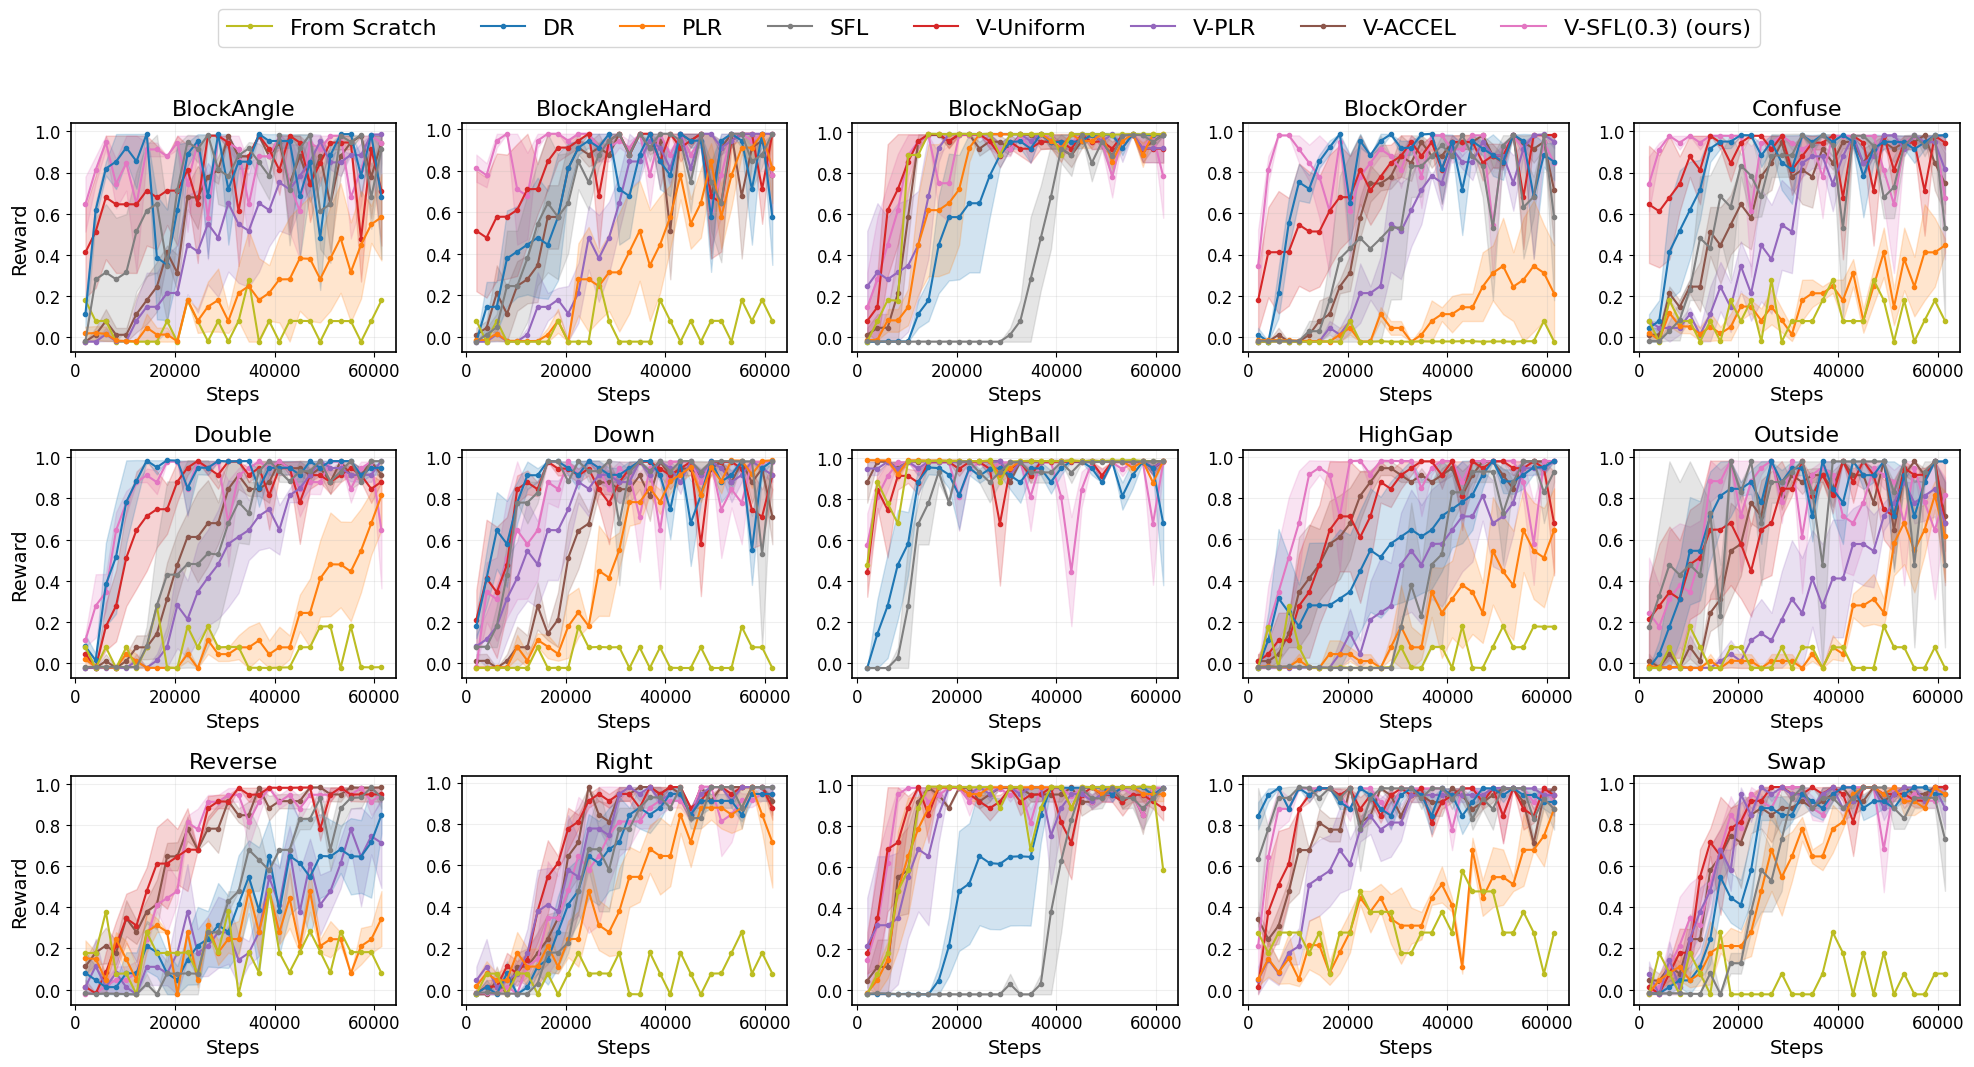

In [92]:

# algorithms = ['Iphyre-DR', 'Iphyre-V-Uniform', 
#                'Iphyre-Robust-PLR', 'Iphyre-V-Robust-PLR', 
#                'Iphyre-Accel', 'Iphyre-V-Accel',
#                'Iphyre-V-SFL', ]
import matplotlib.pyplot as plt

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



method_display_config_rotate = {
    'none': {
        'color': default_colors[8],
        'marker': 'o',
        'markersize': 3,
        'label': 'From Scratch',
    },
    'DR': {
        'color': default_colors[0],
        'marker': 'o',
        'markersize': 3,
        'label': 'DR',
    },
    'PLR': {
        'color': default_colors[1],
        'marker': 'o',
        'markersize': 3,
        'label': 'PLR',
    },
    'Accel': {
        'color': default_colors[2],
        'marker': 'o',
        'markersize': 3,
        'label': 'ACCEL',
    },
    'SFL': {
        'color': default_colors[7],
        'marker': 'o',
        'markersize': 3,
        'label': 'SFL',
    },
    'VUniform': {
        'color': default_colors[3],
        'marker': 'o',
        'markersize': 3,
        'label': 'V-Uniform',
    },
    'VPLR': {
        'color': default_colors[4],
        'marker': 'o',
        'markersize': 3,
        'label': 'V-PLR',
    },
    'VAccel': {
        'color': default_colors[5],
        'marker': 'o',
        'markersize': 3,
        'label': 'V-ACCEL',
    },
    'VSFL': {
        'color': default_colors[6],
        'marker': 'o',
        'markersize': 3,
        'label': 'V-SFL(0.3) (ours)',
    },
}
methods_to_plot_rotate = method_display_config_rotate.keys()

method_display_config_shift = method_display_config_rotate
methods_to_plot_shift = method_display_config_shift.keys()

def simplify_name(metric):
    # IphyreAdversarialHandDesignBlockAngleEnv-v0 -> Block Angle
    return metric.split('-v0')[0].split('IphyreAdversarialHandDesign')[-1].split('Env')[0]

chart_metrics = [(metric, simplify_name(metric)) for metric in metrics]

filename = 'exp3-singletask.png'

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure with subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.ravel()

plt.rcParams.update({'font.size': 14})  # Increase overall font size

print(len(chart_metrics))

gap = 1
end = 30

# Iterate through metrics and plot each one
for idx, (metric_id, metric_name) in enumerate(chart_metrics):
    ax = axes[idx]
    
    for method, df in method_dfs[metric_id].items():
        if method in methods_to_plot_rotate:
            # Sample every 5th datapoint
            sampled_df = df.iloc[:end:gap]
            mean = sampled_df[('mean_agent_return', 'mean')]
            stderr = sampled_df[('mean_agent_return', 'stderr')]
            ax.plot(sampled_df.index, mean, 
                   label=method_display_config_rotate[method]['label'],
                   marker='o', markersize=3,
                   color=method_display_config_rotate[method]['color'])
            ax.fill_between(sampled_df.index, mean - stderr, mean + stderr,
                          alpha=0.2, color=method_display_config_rotate[method]['color'])
            
    ax.set_xlabel('Steps', fontsize=14)
    if idx % 5 == 0:
        ax.set_ylabel('Reward', fontsize=14)
    ax.set_title(metric_name, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='-', alpha=0.2)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

# Add legend at the top of the figure
handles, labels = axes[0].get_legend_handles_labels()

def find_index(array, condition):
    return next((i for i, x in enumerate(array) if condition(x)), -1)

sorted_pairs = sorted(zip(handles, labels), 
                     key=lambda x: find_index(method_display_config_rotate.items(), 
                                            lambda y: y[1]['label'] == x[1]))
sorted_handles, sorted_labels = zip(*sorted_pairs)

fig.legend(sorted_handles, sorted_labels, loc='center', 
          bbox_to_anchor=(0.5, 1.05), ncol=8, fontsize=16)

plt.tight_layout()
if filename:
    plt.savefig(filename, dpi=100, bbox_inches='tight')
plt.show()


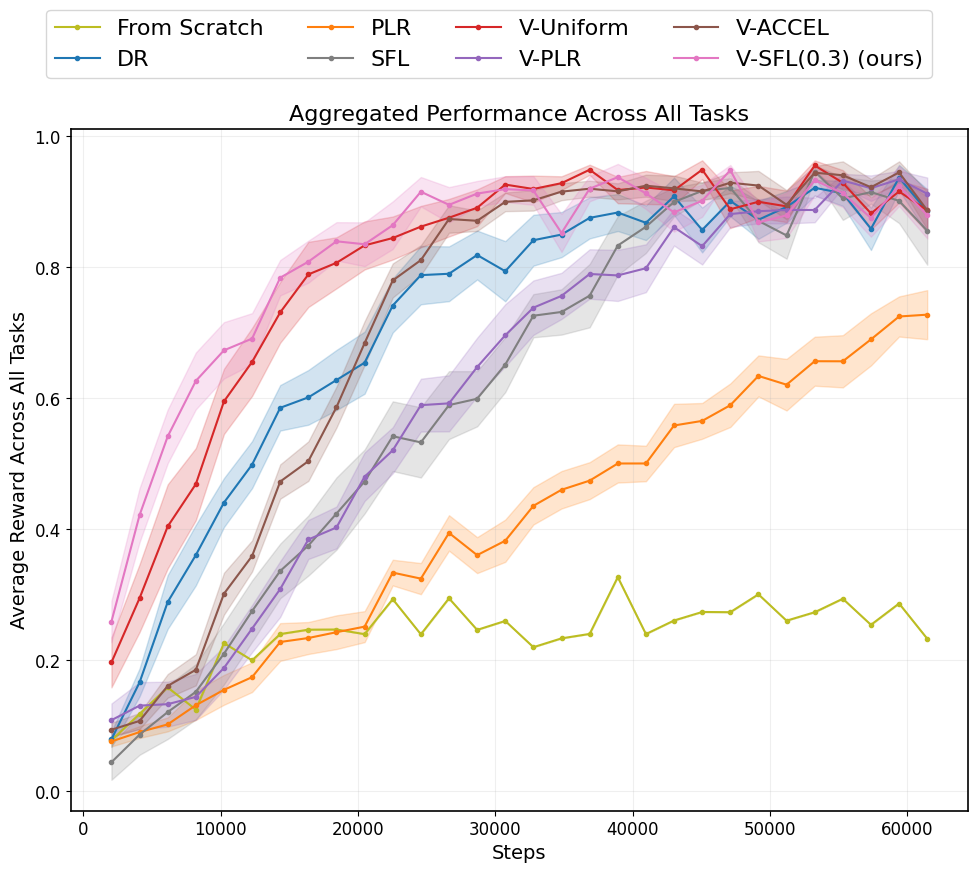

In [94]:
import matplotlib.pyplot as plt

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

method_display_config_rotate = {
    'none': {
        'color': default_colors[8],
        'marker': 'o',
        'markersize': 3,
        'label': 'From Scratch',
    },
    'DR': {
        'color': default_colors[0],
        'marker': 'o',
        'markersize': 3,
        'label': 'DR',
    },
    'PLR': {
        'color': default_colors[1],
        'marker': 'o',
        'markersize': 3,
        'label': 'PLR',
    },
    'Accel': {
        'color': default_colors[2],
        'marker': 'o',
        'markersize': 3,
        'label': 'ACCEL',
    },
    'SFL': {
        'color': default_colors[7],
        'marker': 'o',
        'markersize': 3,
        'label': 'SFL',
    },
    'VUniform': {
        'color': default_colors[3],
        'marker': 'o',
        'markersize': 3,
        'label': 'V-Uniform',
    },
    'VPLR': {
        'color': default_colors[4],
        'marker': 'o',
        'markersize': 3,
        'label': 'V-PLR',
    },
    'VAccel': {
        'color': default_colors[5],
        'marker': 'o',
        'markersize': 3,
        'label': 'V-ACCEL',
    },
    'VSFL': {
        'color': default_colors[6],
        'marker': 'o',
        'markersize': 3,
        'label': 'V-SFL(0.3) (ours)',
    },
}
methods_to_plot_rotate = method_display_config_rotate.keys()

method_display_config_shift = method_display_config_rotate
methods_to_plot_shift = method_display_config_shift.keys()

def simplify_name(metric):
    return metric.split('-v0')[0].split('IphyreAdversarialHandDesign')[-1].split('Env')[0]

chart_metrics = [(metric, simplify_name(metric)) for metric in metrics]

filename = 'exp3-singletask-aggregated.png'

# Create figure with single plot
fig, ax = plt.subplots(figsize=(10, 8))

plt.rcParams.update({'font.size': 14})

gap = 1
end = 30

# Initialize dictionary to store aggregated data
aggregated_data = {}

# Aggregate data across all metrics
for metric_id, _ in chart_metrics:
    for method, df in method_dfs[metric_id].items():
        if method in methods_to_plot_rotate:
            sampled_df = df.iloc[:end:gap]
            mean_values = sampled_df[('mean_agent_return', 'mean')]
            stderr_values = sampled_df[('mean_agent_return', 'stderr')]
            
            if method not in aggregated_data:
                aggregated_data[method] = {
                    'means': [],
                    'stderrs': []
                }
            
            aggregated_data[method]['means'].append(mean_values)
            aggregated_data[method]['stderrs'].append(stderr_values)

# Plot aggregated data
for method in methods_to_plot_rotate:
    if method in aggregated_data:
        # Calculate mean and standard error across all metrics
        mean_across_metrics = pd.concat(aggregated_data[method]['means'], axis=1).mean(axis=1)
        stderr_across_metrics = np.sqrt(np.sum(np.square(pd.concat(aggregated_data[method]['stderrs'], axis=1)), axis=1)) / len(chart_metrics)
        
        ax.plot(sampled_df.index, mean_across_metrics,
                label=method_display_config_rotate[method]['label'],
                marker='o', markersize=3,
                color=method_display_config_rotate[method]['color'])
        ax.fill_between(sampled_df.index, 
                       mean_across_metrics - stderr_across_metrics,
                       mean_across_metrics + stderr_across_metrics,
                       alpha=0.2, color=method_display_config_rotate[method]['color'])

ax.set_xlabel('Steps', fontsize=14)
ax.set_ylabel('Average Reward Across All Tasks', fontsize=14)
ax.set_title('Aggregated Performance Across All Tasks', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='-', alpha=0.2)
for spine in ax.spines.values():
    spine.set_linewidth(1.2)

# Add legend
handles, labels = ax.get_legend_handles_labels()
sorted_pairs = sorted(zip(handles, labels), 
                     key=lambda x: find_index(method_display_config_rotate.items(), 
                                            lambda y: y[1]['label'] == x[1]))
sorted_handles, sorted_labels = zip(*sorted_pairs)

fig.legend(sorted_handles, sorted_labels, loc='center', 
          bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=16)

plt.tight_layout()
if filename:
    plt.savefig(filename, dpi=100, bbox_inches='tight')
plt.show()
